In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

# Klasyfikatory wieloklasowe

Podczas gdy klasyfikatory binarne rozróżniają dwie klasy, klasyfikatory wieloklasowe (Multiclass Classification) mogą rozróżniać więcej niż dwie klasy.

Scikit-Learn automatycznie wykrywa użycie binarnego algorytmu klasyfikacji do zadania klasyfikacji wieloklasowej i automatycznie uruchamia **one-versus-all (OvA)** (z wyjątkiem klasyfikatorów SVM, dla których używa **one-versus-one (OvO)**). 

In [21]:
np.random.seed(42)

from tensorflow.examples.tutorials.mnist import input_data

# Import data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

X = mnist.train.images # Returns np.array
y = np.asarray(mnist.train.labels, dtype=np.int32)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


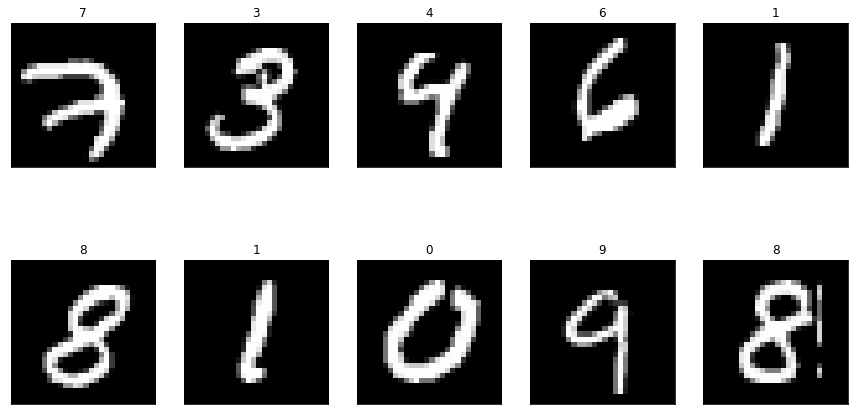

In [3]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8), subplot_kw={'xticks': (), 'yticks': ()})
for target, image, ax in zip(y, X, axes.ravel()):
    ax.imshow(image.reshape(28, 28), cmap=plt.cm.gist_gray)
    ax.set_title(target)
plt.show() 

In [4]:
X_train = mnist.train.images 
y_train = mnist.train.labels
X_test = mnist.test.images
y_test = mnist.test.labels

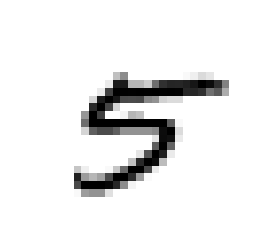

In [5]:
import matplotlib
import matplotlib.pyplot as plt
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

# Zad. 

Stwórzmy **LogisticRegression** i uczmy go na całym zbiorze treningowym.


In [22]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=42)

clf.fit(X_train, y_train)
clf.predict([some_digit])

array([5], dtype=uint8)

 * Scikit-Learn faktycznie nauczył 10 klasyfikatorów binarnych, uzyskał swoje oceny decyzyjne dla obrazu i wybrał klasę z najwyższym wynikiem. 
 * Aby zobaczyć, że tak właśnie jest, możesz wywołać metodę **decision_function()**. 

In [23]:
some_digit_scores = clf.decision_function([some_digit])
some_digit_scores

array([[ -6.02682994, -13.61466292, -10.92838103,  -7.27484896,
         -4.3697061 ,   4.23277966,  -9.31762634,  -3.36634451,
         -6.6788083 , -11.16984699]])

In [24]:
np.argmax(some_digit_scores)

5

In [25]:
clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

# OneVsOneClassifier vs OneVsRestClassifier

Jeśli chcesz zmusić ScikitLearn do korzystania z 
 *  one-versus-one
 *  one-versus-all

możesz użyć klas 

 * OneVsOneClassifier 
 * OneVsRestClassifier. 
 
Po prostu utwórz instancję i przekaż klasyfikator binarny do jej konstruktora. 

In [26]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(LogisticRegression(max_iter= 5, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [27]:
len(ovo_clf.estimators_)

45

 * Teraz oczywiście chcesz ocenić wydajność klasyfikatora wieloklasowego.

 * Jak zwykle, chcemy użyć cross-validacji. 


In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(ovo_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.93494028, 0.93530791, 0.93797054])

# Error Analysis

Po pierwsze, możesz spojrzeć na **confusion matrix**. 

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred  = cross_val_predict(clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

To dużo liczb. Często wygodniej jest spojrzeć na wykres:

In [ ]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

* Nasza **confusion matrix** wygląda dość dobrze, ponieważ większość obrazów znajduje się na głównej przekątnej, co oznacza, że zostały poprawnie sklasyfikowane. 

* Piątki wyglądają nieco ciemniej niż pozostałe cyfry, co może oznaczać, że w zestawie danych jest mniej zdjęć o wartości 5 lub że klasyfikator nie działa tak dobrze na 5-ach, jak na innych cyfrach. 

* W rzeczywistości można sprawdzić, czy tak jest.

* Skoncentrujmy wątek na błędach. Po pierwsze, musimy podzielić każdą wartość w **confusion matrix** przez liczbę obrazów w odpowiedniej klasie, aby móc porównać wskaźniki błędów zamiast bezwzględnej liczby błędów:

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Teraz wypełnijmy przekątną zerami, aby zachować tylko błędy i wyprowadźmy wynik:

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

### Teraz możesz wyraźnie zobaczyć rodzaje błędów, które tworzy klasyfikator. 

 * Pamiętaj, że wiersze reprezentują rzeczywiste klasy, a kolumny reprezentują przewidywane klasy. 

 * Kolumny dla klas 8 i 9 są dość jasne, co oznacza, że wiele obrazów zostało błędnie zaklasyfikowanych jako 8 lub 9. 
 
 * Podobnie, wiersze dla klas 8 i 9 są również dość jasne, informując, że 8s i 9s są często mylone z innymi cyframi. 
 
 * Odwrotnie, niektóre wiersze są dość ciemne, takie jak wiersz 1: oznacza to, że większość 1 jest klasyfikowana poprawnie (kilka jest mylonych z 8, ale to wszystko). 
 
 * Zauważ, że błędy nie są idealnie symetryczne: np. jest więcej błędnie zaklasyfikowanych 5 jako 8 niż odwrotnie.

* Analiza pojedynczych błędów może również być dobrym sposobem na uzyskanie wglądu w to, co robi klasyfikator i dlaczego jest nieskuteczna.

* Jest to trudniejsze i bardziej czasochłonna. 

* Np. możemy narysować przykłady 3 i 5:

In [ ]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

 * Na rysunku:

    * dwa  bloki (5 × 5) po lewej pokazują cyfry sklasyfikowane jako 3
    * dwa bloki (5 × 5) po prawej pokazują obrazy sklasyfikowane jako 5. 

* Niektóre cyfry, które klasyfikator robi źle (tj. w dolnym lewym i górnym prawym bloku) są tak źle napisane, że nawet człowiek miałby problem z ich klasyfikacją (np. 5 w 8. rzędzie i 1. kolumna naprawdę wygląda jak 3). 

* Jednak większość błędnie wydaje się oczywistym błędem i trudno zrozumieć dlaczego klasyfikator je opełnił

* Powodem jest to, że użyliśmy prostego SGDClassifier, który jest modelem liniowym.

# Zad

Weźmy 3 klasy:
* 0
* 4
* 9

Naucz model regresji logistycznej i wylicz:

* precision
* recall_score
* f1_score
* accuracy